# Intwari ATLAS v2 - Model
this notebook is focused on the development, training, validation, and analysis of a machine learning model using the dataset processed, merged, populated, and cleaned in the features.ipynb notebook.

In [1]:
# imports
import ee, os, math, joblib
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, tensorflow as tf
from tensorflow import keras
from keras import layers
from ast import literal_eval
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, brier_score_loss
from featuretoolkit import src as ftk

## Setup & Data Ingestion

In [2]:
# magic to disable certain heavy data processing cells when no longer necessary
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line,cell):return

# authenticating & initializing earth engine
from dotenv import load_dotenv
load_dotenv()
ee.Authenticate()
ee.Initialize(project=os.getenv('projectkey'))

# reading config & setting seed + guaranteeing determinism
import yaml
with open('config.yaml','r') as f:config_full=yaml.safe_load(f)
SEED=config_full.get('seed')
RNG=np.random.default_rng(SEED) # initializing global rng
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # suppress tensorflow warnings

dFpath=config_full.get('features')['path']['main'] # get path for main training data
config=config_full.get('model') # specialize config for only model section - no more feature config required
config_path=config.get('path') # path config section

In [3]:
dF=pd.read_csv(dFpath) # loading in training dataset
meta=['key','weight','region_id','fold_id'] # meta columns (non-quantitative non-features)

# select only numeric feature columns
cols=[col for col in dF.columns if col not in meta]
X=dF[cols].astype('float32',copy=False) # float32 because nobody has infinite memory
dF

,key,weight,region_id,fold_id,aspect_cos,aspect_sin,clay_content_b0,clay_content_b10,clay_content_b100,clay_content_b200,...,surface_runoff_24h_sum,surface_runoff_6h_sum,surface_runoff_72h_sum,tri,twi,vwc_kPa0033_0_5cm,vwc_kPa0033_100_200cm,vwc_kPa1500_0_5cm,vwc_kPa1500_100_200cm,snow_flag
0,1,0.009174,823ce7fffffffff,813cfffffffffff,1.176781,-0.739081,0.727348,0.648285,0.478016,0.447955,...,2.055129,2.138805,1.967114,0.413202,-0.115218,0.257414,1.110668,0.399104,0.677761,-0.706969
1,1,0.009174,823ce7fffffffff,813cfffffffffff,-1.403311,-0.260128,0.615053,0.648285,0.384057,0.447955,...,2.055129,2.138805,1.967114,-0.630247,1.498498,0.276323,1.114749,0.618455,0.680209,-0.706969
2,1,0.009174,823ce7fffffffff,813cfffffffffff,1.379457,-0.000796,0.839644,0.871263,0.947809,0.830462,...,2.055129,1.596113,1.967114,-0.194193,0.751367,0.352978,1.131465,0.433176,0.748231,-0.706969
3,1,0.009174,823ce7fffffffff,813cfffffffffff,-0.180713,-1.417856,0.615053,0.759774,0.478016,0.447955,...,2.055129,2.124177,1.967114,0.042107,-0.546235,0.219442,1.085758,0.326697,0.450702,-0.706969
4,1,0.009174,823ce7fffffffff,813cfffffffffff,1.188038,0.718243,0.390461,0.313818,0.102181,0.065449,...,2.055129,2.138805,1.967114,1.256081,-0.250256,0.335765,1.121812,0.745396,0.572739,-0.706969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339766,0,97283.339273,8240c7fffffffff,8140fffffffffff,-0.563581,-1.316996,-0.732497,-0.689583,-1.025323,-0.890817,...,0.174256,-0.662279,0.409294,-0.782715,2.180120,0.852142,0.082639,0.170879,-0.804850,1.414489
4339767,0,97283.339273,8240c7fffffffff,8140fffffffffff,-0.398690,1.373335,-0.732497,-0.689583,-0.931364,-0.986444,...,0.412759,0.307950,0.429089,-0.871796,1.158951,0.996161,0.398367,0.188410,-0.679498,1.414489
4339768,0,97283.339273,8240c7fffffffff,8140fffffffffff,1.179299,-0.734834,-0.620201,-0.689583,-1.025323,-0.986444,...,0.136545,-0.493155,0.386338,-0.280527,-0.166375,1.027560,0.502904,0.318067,-0.629755,1.414489
4339769,0,97283.339273,8240c7fffffffff,8140fffffffffff,-0.921440,1.095059,-0.732497,-0.689583,-0.931364,-0.986444,...,0.176183,-0.645229,0.397336,-0.989593,0.715149,0.979448,0.090964,0.090291,-0.469059,1.414489


the region_id and fold_id columns are categorical (and confirmed to be spatially coherent) indicators that split up the dataset into hexagonal regions for k-fold cross validation.
i'll be recombining the folds into larger, coherent data splits.

### Principal Components Analysis

90.0% variance: 22/59 components
95.0% variance: 28/59 components
99.0% variance: 40/59 components


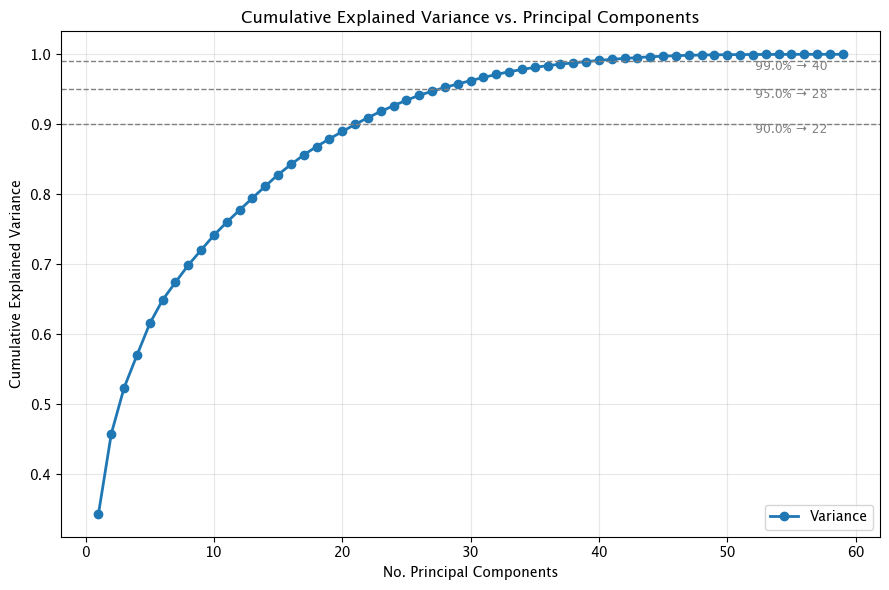

In [4]:
# displayed thresholds for explained variance
thresholds=[0.90,0.95,0.99]  # customize freely

# fit PCA with all components
pca_graph=PCA(n_components=min(len(cols),X.shape[1]),svd_solver='full',random_state=SEED)
pca_graph.fit(X)
cum_var=np.cumsum(pca_graph.explained_variance_ratio_) # cumulative explained variance

# plot, draw threshold lines and collect counts
plt.figure(figsize=(9, 6))
plt.plot(range(1,len(cum_var)+1),cum_var,marker='o',linewidth=2,label='Variance')
for threshold in thresholds:
    n_t=np.argmax(cum_var>=threshold)+1
    plt.axhline(threshold,color='gray',linestyle='--',linewidth=1)
    plt.text(len(cum_var)*0.98,threshold-0.015,f'{threshold:.1%} → {n_t}',ha='right',va='bottom',fontsize=9,color='gray')
    print(f'{threshold:.1%} variance: {n_t}/{len(cols)} components')
plt.xlabel('No. Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Principal Components')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
%%skip # already done @ database/outputs/pca.csv & database/records/pca_model.joblib
# running pca w/ 95% variance
pca=PCA(n_components=0.95,svd_solver='full',random_state=SEED)
X_pca=pca.fit_transform(X) 
pca_cols=[f'pca_{i+1}' for i in range(X_pca.shape[1]) ] # pca column names
dF_pca=pd.concat([dF[meta].reset_index(drop=True),pd.DataFrame(X_pca,columns=pca_cols)],axis=1) # new dataframe w/ pca features

# pca model persistence (saving)
joblib.dump(pca,config_path.get('pca_persist'))
dF_pca.to_csv(config_path.get('pca'),index=False) # saving pca features

In [6]:
dF_pca=pd.read_csv(config_path.get('pca')) # set of all points w/ pca features (add a distinct index column too)
dF_pca

,key,weight,region_id,fold_id,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,...,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28
0,1,0.009174,823ce7fffffffff,813cfffffffffff,7.919922,-1.741628,0.421530,2.041332,1.055858,-0.537992,...,1.770380,4.097381,1.759519,-1.114659,1.351860,-0.127301,0.451046,0.180176,-0.564430,-0.269328
1,1,0.009174,823ce7fffffffff,813cfffffffffff,7.687078,-1.627850,0.872975,2.246955,0.365481,-1.539572,...,1.707271,3.817607,1.820373,-1.021248,0.707671,-0.009865,1.448410,-0.000950,-0.442643,-0.304429
2,1,0.009174,823ce7fffffffff,813cfffffffffff,7.879265,-0.865018,0.777079,2.603141,0.742506,-1.511291,...,2.030154,3.916332,1.870890,-1.105742,0.602352,-0.440551,0.447757,0.136158,-0.561832,-0.093878
3,1,0.009174,823ce7fffffffff,813cfffffffffff,7.671412,-1.299358,-0.024935,2.797749,1.556933,-0.945857,...,2.091853,4.014126,1.770045,-1.260138,0.478387,-0.208456,-0.022478,0.417773,-0.429929,-0.453360
4,1,0.009174,823ce7fffffffff,813cfffffffffff,7.535117,-1.988023,-0.603507,2.611152,2.277035,-0.353623,...,1.908456,4.267641,1.697764,-1.012736,0.264271,-0.209273,0.578155,0.224784,-0.309458,-0.485339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339766,0,97283.339273,8240c7fffffffff,8140fffffffffff,0.050778,-0.565957,-1.977450,-1.549858,-0.855223,-2.301721,...,-0.182621,-0.423734,-0.505760,-0.472187,-0.390146,-0.525690,1.314651,-0.221749,-0.554595,0.013841
4339767,0,97283.339273,8240c7fffffffff,8140fffffffffff,0.508813,-0.726713,-2.254151,-1.366290,-0.695039,-1.862957,...,0.295373,-0.674295,-0.290204,-0.625620,-0.593078,-0.222831,0.234156,0.520278,0.074082,-0.397170
4339768,0,97283.339273,8240c7fffffffff,8140fffffffffff,0.404691,-0.519536,-2.696815,-1.410832,-0.320443,-1.310595,...,-0.244820,-0.106209,-0.372594,-0.520836,0.498768,-0.489555,-0.225902,0.210442,-0.639504,0.031230
4339769,0,97283.339273,8240c7fffffffff,8140fffffffffff,0.236878,-0.456426,-2.198424,-1.337481,-0.853382,-2.020265,...,0.186024,-0.493525,-0.442212,-0.453721,0.093768,-0.677685,0.365460,-0.029513,-0.754673,-0.076128


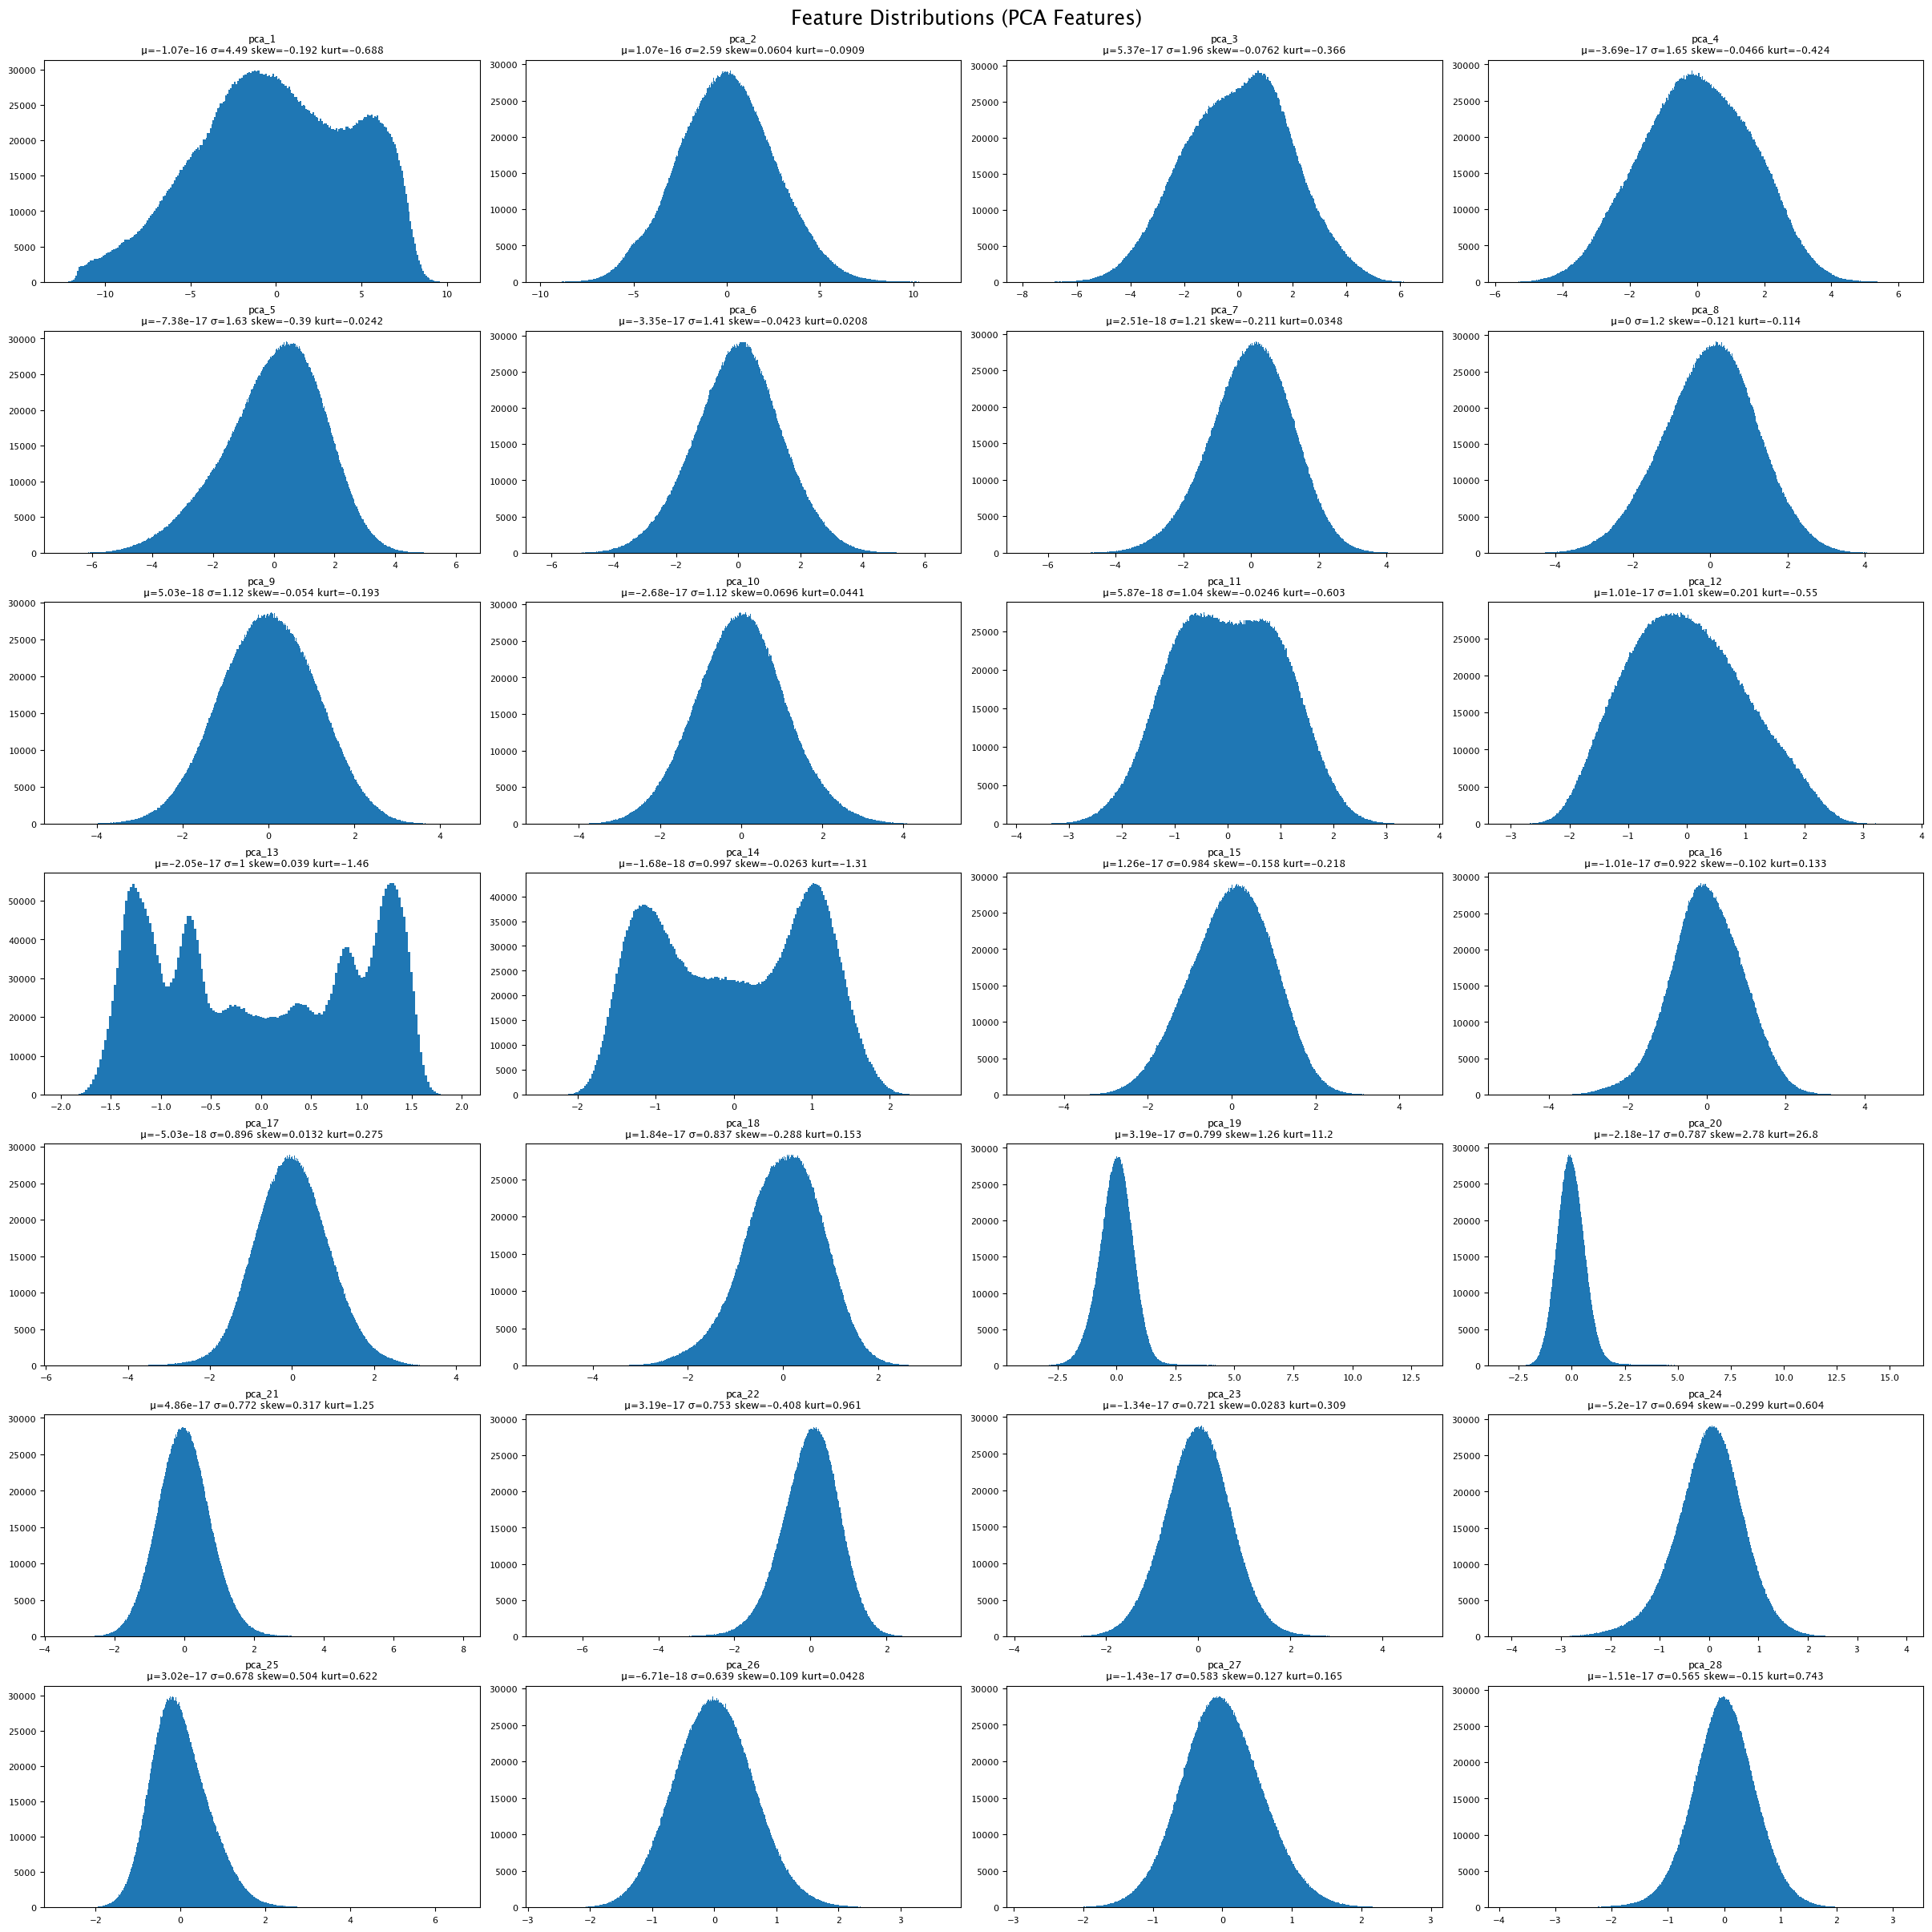

In [7]:
def multiplots(dF,note=None,bins='auto',nrows=7,ncols=4):
    # getting only numeric & non-meta columns
    cols=[c for c in [col for col in dF.columns if col not in meta] if c in dF.select_dtypes(include=[np.number]).columns.tolist()]

    # setting up grid
    fig,axes=plt.subplots(nrows,ncols,figsize=(24,24),constrained_layout=True)
    axes=axes.ravel()

    # loop through all columns and plot
    for idx,col in enumerate(cols):
        ax=axes[idx]
        feature=dF[col]
        # histogram & compute stats
        ax.hist(feature.values,bins=bins,edgecolor='none')
        ax.set_title(f'{col}\nμ={feature.mean():.3g} σ={feature.std(ddof=1):.3g} skew={feature.skew():.3g} kurt={feature.kurt():.3g}',fontsize=9)
        ax.tick_params(axis='both',which='both',labelsize=8)

    # hide unused axes, display overall title
    for plot in range(len(cols),len(axes)):axes[plot].axis('off')
    fig.suptitle(f'Feature Distributions{f' ({note})' if note!=None else ''}',fontsize=18)
    plt.show()

multiplots(dF_pca,note='PCA Features',nrows=7,ncols=4) # distribution of pca features

### Data Splits

In [8]:
ratios=config.get('split_ratio') # train, val, test ratio
assert sum(ratios)==1 and len(ratios)==3 # asserting valid split ratios
folds=np.sort(dF_pca['fold_id'].unique()) # fold ids
splits={}

# iterating through each fold to populate fold-wise splits with arrays of dF_pca indices
for fold in folds:
    idx=dF_pca.index[dF_pca['fold_id']==fold].to_numpy()
    # generating unique permutation each iteration while still maintaining reproducibility due to global seed & rng, then splitting indices
    perm=RNG.permutation(idx)
    n_train=int(len(perm)*ratios[0])
    n_val=int(len(perm)*ratios[1])
    splits[fold]={
        'train_idx':perm[:n_train],
        'val_idx':perm[n_train:n_train+n_val],
        'test_idx':perm[n_train+n_val:]}

splits # split dict organized fold-wise

{'8108bffffffffff': {'train_idx': array([1420626, 1568393, 1186232, 3517826, 1186189, 1568338, 1186208,
         1568364, 1186180, 1186186, 3517843, 2045191, 1186213, 2045142,
         1186169, 1186219, 1568403, 1568374, 3517836, 3517827, 1568425,
         3517839, 1568368, 2045150, 2045204, 2045160, 3517834, 2045165,
         2045209, 2045199, 1186162, 1186197, 2073970, 1420610, 1186187,
         3517837, 1420602, 2045168, 2045153, 3517813, 2045132, 1420627,
         3517863, 1568366, 1186236, 1568385, 1186181, 2045195, 1186194,
         1186216, 1568392, 1568411, 2045126, 3517848, 1568400, 1420628,
         1186138, 1186136, 3517861, 1568404, 3517823, 1420596, 1568432,
         2045134, 3517860, 1186222, 1186191, 2045173, 1186144, 2045127,
         1186182, 2045129, 3517845, 1186200, 2045175, 1568344, 1568343,
         1568352, 1568380, 2045125, 1568350, 2045184, 3517821, 2045201,
         2045123, 1568347, 1568340, 2045163, 3517810, 1186218, 2045128,
         3517832, 2045218, 15683

In [9]:
# collecting basic fold stats, merging into superfolds
fold_stats=[]
for fid,s in splits.items(): # looping through folds
    pos=int((dF_pca.loc[s['train_idx'],'key']==1).sum()+(dF_pca.loc[s['val_idx'],'key']==1).sum()+(dF_pca.loc[s['test_idx'],'key']==1).sum())
    bg=int((dF_pca.loc[s['train_idx'],'key']==0).sum()+(dF_pca.loc[s['val_idx'],'key']==0).sum()+(dF_pca.loc[s['test_idx'],'key']==0).sum())
    fold_stats.append((fid,pos,bg,pos+bg))
superfolds={i:{'folds':[],'pos':0,'bg':0,'n':0} for i in range(config.get('folds'))}
for fid,pos,bg,n in sorted(fold_stats,key=lambda x:x[3],reverse=True): # largest folds first
    target=min(superfolds,key=lambda k:superfolds[k]['n'])
    superfolds[target]['folds'].append(fid)
    superfolds[target]['pos']+=pos
    superfolds[target]['bg']+=bg
    superfolds[target]['n']+=n

# assembling merged splits together
merged_splits={}
for sf_id,info in superfolds.items():
    merged_splits[sf_id]={'train_idx':[],'val_idx':[],'test_idx':[]}
    for fold in info['folds']: # looping through folds in superfold
        s=splits[fold]
        merged_splits[sf_id]['train_idx'].extend(s['train_idx'])
        merged_splits[sf_id]['val_idx'].extend(s['val_idx'])
        merged_splits[sf_id]['test_idx'].extend(s['test_idx'])
    for k in ('train_idx','val_idx','test_idx'): # converting to numpy arrays
        merged_splits[sf_id][k]=np.array(merged_splits[sf_id][k],dtype=int)

# summary printout
totals,pos_list,neg_list,ratios=[],[],[],[]
for sf_id,s in merged_splits.items(): # looping through superfolds
    pos=int((dF_pca.loc[s['train_idx'],'key']==1).sum()+(dF_pca.loc[s['val_idx'],'key']==1).sum()+(dF_pca.loc[s['test_idx'],'key']==1).sum())
    bg=int((dF_pca.loc[s['train_idx'],'key']==0).sum()+(dF_pca.loc[s['val_idx'],'key']==0).sum()+(dF_pca.loc[s['test_idx'],'key']==0).sum())
    total=pos+bg
    ratio=pos/bg
    totals.append(total)
    pos_list.append(pos)
    neg_list.append(bg)
    ratios.append(ratio)
    print(f'SF_{sf_id}: {len(info['folds'])} subfolds, total={total}, pos={pos}, bg={bg}, ratio={ratio:.3f}')


SF_0: 36 subfolds, total=542477, pos=173315, bg=369162, ratio=0.469
SF_1: 36 subfolds, total=542469, pos=152885, bg=389584, ratio=0.392
SF_2: 36 subfolds, total=542478, pos=138661, bg=403817, ratio=0.343
SF_3: 36 subfolds, total=542472, pos=162061, bg=380411, ratio=0.426
SF_4: 36 subfolds, total=542443, pos=119822, bg=422621, ratio=0.284
SF_5: 36 subfolds, total=542418, pos=130614, bg=411804, ratio=0.317
SF_6: 36 subfolds, total=542533, pos=118381, bg=424152, ratio=0.279
SF_7: 36 subfolds, total=542481, pos=77580, bg=464901, ratio=0.167


## Model Architecture & Training

we first train a spatial–temporal Cox (Poisson) process with positive events (landslides) and background (non-event) samples as chosen in random clusters in the features.ipynb notebook.  
let each training row $j$ have:
- a binary label $y_j \in \{0,1\}$,
- a sample weight $w_j > 0$,
- a feature vector $x_j \in \mathbb{R}^D$ (PCA features).

because background samples vastly outnumber positives, we rescale background weights by a constant factor $1/s$ so that the *total* positive and background weights are approximately equal on the combined training set:
$$
\sum_{j: y_j=1} w^{(\mathrm{pos})}_j
\;=\;
\sum_{j: y_j=0} \frac{w^{(\mathrm{bg})}_j}{s}.
$$

where $s$ is the global scaling and $s>0$ and $\log S$ denotes $\ln(S)$

this rescaling stabilizes training and makes folds comparable, but it shifts the learned log-intensity $\mu(x)$ by $+\log S$.  
so, to recover absolute intensity $\lambda$ (events per area–time) upon inference, we must subtract this offset:
$$
\lambda(x) \,=\, \exp(\mu(x) - \log S).
$$

In [10]:
# computing total weights for positives & background
sum_pos=dF_pca.loc[dF_pca['key']==1,'weight'].sum()
sum_bg=dF_pca.loc[dF_pca['key']==0,'weight'].sum()

# computing scaling factor (so both totals are comparable) (this is a necessary step because training just doesnt work otherwise)
s=sum_bg/max(sum_pos,1e-12)
log_s=np.log(s) # natural log of s (saved for later)

# create scaled column
dF_pca['weight_scaled']=dF_pca['weight'].copy()
dF_pca.loc[dF_pca['key']==0,'weight_scaled']/=s

# printout
print(f'background rescaled by 1/s = {1/s:.3e} (log(s) = {log_s:.3f})')
print(f'\noriginal weights\n∑w (positives): {dF_pca.loc[dF_pca['key']==1,'weight'].sum():.3e}\n∑w (background): {dF_pca.loc[dF_pca['key']==0,'weight'].sum():.3e}')
print(f'\nrescaled weights\n∑w (positives): {dF_pca.loc[dF_pca['key']==1,'weight_scaled'].sum():.3e}\n∑w (background): {dF_pca.loc[dF_pca['key']==0,'weight_scaled'].sum():.3e}')

background rescaled by 1/s = 2.315e-08 (log(s) = 17.581)

original weights
∑w (positives): 7.356e+03
∑w (background): 3.178e+11

rescaled weights
∑w (positives): 7.356e+03
∑w (background): 7.356e+03


### Explanation & Mathematical Basis

#### 1. Intensity Model

we model the event intensity at covariates ${x}$ as
$$
\lambda(x)=\exp(\mu(x)),
$$
where the log-intensity is a linear head on a fixed feature map $\phi(x) \in \mathbb{R}^M$:
$$
\mu(x)=w^\top\phi(x) + b.
$$

*(note that we already obtained $\phi(x)$ from PCA features; the specific construction is not needed here. also, mu is clipped in practice)*

#### 2. Cox / Poisson Log-Likelihood

with data $\mathcal{D}=\{(x_j, y_j, w_j)\}_{j=1}^N$, the continuous Cox-process log-likelihood

$$
\log \mathcal{L}(\lambda)=\sum_{i=1} \log \lambda(x_i)-\int_{\mathcal{X}} \lambda(x) dx,
$$

can be approximated by positive and background sums:
$$
\log \mathcal{L}(\lambda)=\sum_{j: y_j=1} w_j \log \lambda(x_j)-\sum_{j: y_j=0} w_j \lambda(x_j)-\Omega(w),
$$
where the second term is a Monte-Carlo estimate of $\int \lambda$ using background samples, and $\Omega(w)$ is a regularizer (i ended up using ridge (l2)).

substituting $\lambda=\exp(\mu)$ gives the negative log-likelihood (NLL):
$$
\mathcal{J}(w, b)=-\sum_{j: y_j=1} w_j \mu(x_j)+\sum_{j: y_j=0} w_j  \exp\!\big(\mu(x_j)\big)+\Omega(w)
$$

also, for comparable learning curves across batches/splits, we monitor
$$\mathrm{NLL\_per\_pos}=\frac{-\sum_{y_j=1} w_j \mu(x_j)+\sum_{y_j=0} w_j e^{\mu(x_j)}+\Omega(w)}{\sum_{y_j=1} w_j}
$$

rescaling background weights $w^{(\mathrm{bg})} \!\to\! w^{(\mathrm{bg})}/s$ multiplies the integral term by $1/s$.  
during optimization, the model compensates by increasing $\mu$ by $\log S$ so that $\exp(\mu-\log S)$ sits on the absolute scale.  
at inference, we therefore compute absolute intensity as
$$
\lambda_{\mathrm{abs}}(x) \;=\; \exp\!\big(\mu(x) - \log S\big).
$$

#### 3. Spatiotemporal Uncertainty via Subsampling Process

a single labeled event may have spatial and temporal uncertainty.  
we draw $K$ subsamples $\{x_i\}_{i=1}^K$ from the event’s uncertainty kernel (spatial radius, time interval).
see how $K$ is calculated interactively here: https://www.desmos.com/calculator/9zixtxpbk8
each subsample has PCA features and yields
$$
\mu_i = \mu(x_i),\;\;\lambda_i = \exp\!\big(\mu_i - \log S\big)
$$

- for positives, subsamples contribute to the first sum in $\mathcal{J}$.
- for background, subsamples approximate the integral term in $\mathcal{J}$.

this turns training into a Monte-Carlo estimate of the continuous likelihood where uncertainty is explicitly propagated.

#### 4. Cross-Validation and Model Selection

with spatially coherent-ish superfolds $s=1,\dots,S$, for each $s$ we train on all other folds and validate on $s$.  
the validation criterion is
$$
\mathrm{val\_NLL\_per\_pos}(s)=\frac{-\sum_{j\in\mathrm{val}(s),\,y_j=1} w_j \mu(x_j)+\sum_{j\in\mathrm{val}(s),\,y_j=0} w_j e^{\mu(x_j)}+\Omega(w)}{\sum_{j\in\mathrm{val}(s),\,y_j=1} w_j}
$$
we select the superfold model with the lowest validation value as the final model for inference.
*please note that any model denoted with a given superfold was trained on every superfold but the one denoted* 

#### 5. Converting Absolute Intensity to Probability in a Spacetime Window

given a spacetime window $W = A \Delta t$ with area $A$ and time interval $\Delta t$, the Poisson model implies
$$
P(\ge 1 \text{ event in } W)=1-\exp(-\Lambda),\;\;\text{where}\;\;\Lambda = \iint_{W} \lambda(x)\, dx\,dt
$$

if $W$ is small or $\lambda$ varies slowly over $W$, we instead can just use the constant approximation
$$
\Lambda\;\approx\;\overline{\lambda}\,A\,\Delta t
$$

given that we have $K$ subsamples drawn uniformly within $W$ and evaluated to $\lambda_i=\exp(\mu_i-\log S)$, then
$$
\overline{\lambda} = \frac{1}{K}\sum_{i=1}^{K} \lambda_i,\;\;P(\ge 1 \text{ in } W) \;=\; 1 - \exp\!\left(-\,\overline{\lambda}\,A\,\Delta t\right)
$$

#### 6. Units and Stuff

- $\mu$ is dimensionless (log-rate).
- $\lambda$ has units of events per area per time, matching preprocessing:
  - if area is in $\mathrm{km}^2$ and time in seconds, then $\lambda$ is in $\mathrm{events}\cdot\mathrm{km}^{-2}\cdot\mathrm{s}^{-1}$.
- Use $A$ in $\mathrm{km}^2$ and $\Delta t$ in seconds so that $\Lambda$ is dimensionless and $P \in [0,1]$.


thanks for reading

### Model Construction

In [11]:
# initialize hyperparameters
H=config.get('hyperparameters')
# casting hyperparameters to correct types (strings to float or tuple)
for k,v in H.items():
    if type(v)==str and 'e' in v:H[k]=float(v)
    elif type(v)==str and '(' in v:H[k]=literal_eval(v)

# rff+linear head
class RandomFourierFeatures(layers.Layer):
    # initialization
    def __init__(self,input_dim,output_dim,gamma):
        super().__init__() # parent init (everything will wrap into a bigger model)
        W_init=RNG.normal(scale=np.sqrt(2*gamma),size=(input_dim,output_dim))
        b_init=RNG.uniform(0,2*np.pi,size=(output_dim,))
        self.W=self.add_weight( # fixed weights
            name='W',shape=(input_dim,output_dim),
            initializer=tf.constant_initializer(W_init),trainable=False)
        self.b=self.add_weight( # fixed biases
            name='b',shape=(output_dim,),
            initializer=tf.constant_initializer(b_init),trainable=False)
    # forward pass
    def call(self,x):
        z=tf.matmul(x,self.W)+self.b
        return tf.sqrt(2/tf.cast(tf.shape(self.W)[1],tf.float32))*tf.cos(z)

# rff+linear lgcp model
class RFF_LGCP(keras.Model):
    # initialization
    def __init__(self,input_dim,rff_dim,gamma,l2,mu_clip):
        super().__init__() # parent init
        self.rff=RandomFourierFeatures(input_dim,rff_dim,gamma) # rff layer
        self.mu_clip=mu_clip # clipping range for mu
        self.linear=layers.Dense(1,use_bias=True,kernel_regularizer=keras.regularizers.l2(l2),bias_initializer=tf.constant_initializer(-5)) # linear layer w/ l2 regularization against overfit
    # forward pass
    def call(self,X):
        phi=self.rff(X) # this phi has nothing to do with the phi in features.ipynb
        mu=self.linear(phi)
        return tf.clip_by_value(mu,self.mu_clip[0],self.mu_clip[1])

# cox trainer
class CoxTrainer(keras.Model):
    # intialization
    def __init__(self,lgcp_model):
        super().__init__() # parent init
        self.lgcp_model=lgcp_model
    # reduce terms helper (just the math)
    def _reduce_terms(self,y,w,mu,add_reg_losses):
        pos=tf.cast(tf.equal(y,1),tf.float32)
        L_pos=-tf.reduce_sum(w*pos*mu)
        L_neg=tf.reduce_sum(w*(1-pos)*tf.exp(mu)) # times lambda
        reg=tf.add_n(self.lgcp_model.losses) if (add_reg_losses and self.lgcp_model.losses) else 0
        nll_pos_per_event=L_pos/tf.reduce_sum(w*pos)+1e-12
        return L_pos+L_neg+reg,nll_pos_per_event # L_pos+L_neg+reg is total loss
    
    # training step
    def train_step(self,data):
        # unpacking then reshaping y & w to column vectors
        X,y,w=data # unpacking data
        y=tf.cast(tf.reshape(y,(-1,1)),tf.float32)
        w=tf.cast(tf.reshape(w,(-1,1)),tf.float32)
        # gradient tape for automatic differentiation then compute & apply gradients
        with tf.GradientTape() as tape: total,nll_pos_evt=self._reduce_terms(y,w,self.lgcp_model(X,training=True),add_reg_losses=True) # gradient tape for automatic differentiation
        grads=tape.gradient(total,self.trainable_variables)
        if H.get('grad_clip'):grads=[tf.clip_by_norm(g,H['grad_clip']) if g is not None else None for g in grads] # gradient clipping (important)
        self.optimizer.apply_gradients(zip(grads,self.trainable_variables))
        return {'loss': total,'nll_pos_per_event': nll_pos_evt} # return

    # evaluation step
    def test_step(self,data):
        # unpacking then reshaping y & w to column vectors
        X,y,w=data
        y=tf.cast(tf.reshape(y,(-1,1)),tf.float32)
        w=tf.cast(tf.reshape(w,(-1,1)),tf.float32)
        mu=self.lgcp_model(X,training=False) # forward pass
        _,nll_pos_evt=self._reduce_terms(y,w,mu,add_reg_losses=False) # compute nll
        return {'loss': nll_pos_evt,'nll_pos_per_event': nll_pos_evt} # return

# helper for assembling datasets for training loop
# basically just a tf.data.Dataset.from_tensor_slices wrapper
def make_dataset(df,idx,features,ycol,wcol,batch,shuffle=False):
    X=df.loc[idx,features].to_numpy(np.float32)
    y=df.loc[idx,ycol].to_numpy(np.float32)
    w=df.loc[idx,wcol].to_numpy(np.float32)
    ds=tf.data.Dataset.from_tensor_slices((X,y,w))
    if shuffle:ds=ds.shuffle(buffer_size=min(200_000,len(idx)),seed=SEED)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

# training function
def train_rff_lgcp(df,split,H):
    features=[c for c in df.columns if c.startswith('pca_')] # detecting feature columns
    ds_tr=make_dataset(df,split['train_idx'],features,'key','weight_scaled',H['batch_size'],shuffle=True) # training dataset
    ds_va=make_dataset(df,split['val_idx'],features,'key','weight_scaled',H['batch_size']) # validation dataset
    model=RFF_LGCP(len(features),H['rff_dim'],H['rff_gamma'],H['l2'],H['mu_clip'],SEED) # initializing model
    trainer=CoxTrainer(model) # wrapping model in trainer
    # using AdamW optimizer rather than Adam (weight decay is important) then define callbacks & fit model then return
    opt=keras.optimizers.AdamW(learning_rate=H['learning_rate'],weight_decay=H['weight_decay'])
    trainer.compile(optimizer=opt)
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor='val_nll_pos_per_event',mode='min',factor=0.5,patience=H['plateau_patience'],min_delta=H['min_delta'],min_lr=H['min_lr'],verbose=1),# reduce lr on plateau
        keras.callbacks.EarlyStopping(monitor='val_nll_pos_per_event',mode='min',patience=H['patience'],min_delta=H['min_delta'],restore_best_weights=True,verbose=1)] # early stopping based on patience
    trainer.fit(ds_tr,validation_data=ds_va,epochs=H['epochs'],callbacks=callbacks,verbose=1)
    return trainer,model,features

In [12]:
%%skip # already done @ database/models/
# initializing training loop & results dict 
# going to loop through superfolds and train new weights each time both for k-fold CV and to pick the best one
results={}
for sf_id,split in merged_splits.items(): 
    print(f'\n[superfold_{sf_id}] training on all others, validating on this one...') # FROM THIS POINT, THE SUPERFOLD_ID SPECIFIES WHICH ONE IS EXCLUDED

    # retrieving train/val/test indices
    train_idx=np.concatenate([merged_splits[i]['train_idx'] for i in [j for j in list(merged_splits.keys()) if j!=sf_id]]) # making sure to exclude current superfold
    val_idx=merged_splits[sf_id]['val_idx']
    test_idx=merged_splits[sf_id]['test_idx']
    split_combined={'train_idx': train_idx,'val_idx': val_idx,'test_idx': test_idx}

    # training, saving model to specified path (config)
    trainer,model,features=train_rff_lgcp(dF_pca,split_combined,H)
    save_dir=config_path.get('models')
    os.makedirs(save_dir,exist_ok=True)
    model.save_weights(f'{save_dir}/rff_lgcp_sf{sf_id}.weights.h5')

    # evaluating on test set
    ds_te=make_dataset(dF_pca,test_idx,features,H['label_col'],H['weight_col'],H['batch_size'])
    eval_test=trainer.evaluate(ds_te,return_dict=True,verbose=0)

    # nice training history & diagnostics printout during training loop (keep for hyperparameter tuning)
    print(f'[sf {sf_id}]  val_nll/pos={trainer.history.history['val_nll_pos_per_event'][-1]:.4f} | test_nll/pos={eval_test['nll_pos_per_event']:.4f}')
    results[sf_id]=eval_test # updating results

## Inference

### Assembling Everything

In [13]:
# finally defining the ATLAS class for loading trained models and performing inference
class ATLAS:
    def __init__(self,dF_pca,merged_splits,H,save_dir=config_path.get('models'),sf_id=None,verbose=True):
        # initialization; loads & builds from best superfold model by default unless specified otherwise (from models directory as per config)
        self.df=dF_pca
        self.splits=merged_splits
        self.H=H
        self.save_dir=save_dir
        # feature columns (ordered pca_1..pca_K)
        self.feats=sorted([c for c in self.df.columns if c.startswith('pca_')],key=lambda c:int(c.split('_')[1]))
        self.D=len(self.feats)
        # choose best superfold unless specified otherwise
        if sf_id is None:self.sf_id,self.sf_val_score=self._pick_best_superfold(verbose=verbose)
        else:self.sf_id,self.sf_val=sf_id,None

        # build & load chosen model for inference
        self.model=RFF_LGCP(self.D,H['rff_dim'],H['rff_gamma'],H['l2'],H['mu_clip'])
        _=self.model(tf.zeros((1,self.D),dtype=tf.float32))
        wpath=os.path.join(self.save_dir,f'rff_lgcp_sf{self.sf_id}.weights.h5')
        self.model.load_weights(wpath)
        if verbose:print(f'ATLAS: loaded superfold {self.sf_id} @ {wpath}')

        # default reference window for window-aware scaling (can be overridden at call time though)
        self.ref_area_km2=np.pi*17.0**2 # hardcoding this here however because the dataset was trained on an avg radius of 17 but change at your own risk
        self.ref_dt_sec=3600.0 # really wouldn't recommend changing this beyond an hour since the data is only relevant for hour buckets

    # pick best sf by val nll/pos
    def _pick_best_superfold(self,verbose=True):
        scores={}
        for sf in sorted(self.splits.keys()): # looping through existing models directory and loading them up
            wpath=os.path.join(self.save_dir,f'rff_lgcp_sf{sf}.weights.h5')
            if not os.path.exists(wpath):
                if verbose:print(f'[skip] no weights for sf {sf} @ {wpath}')
                continue
            m=RFF_LGCP(self.D,self.H['rff_dim'],self.H['rff_gamma'],self.H['l2'],self.H['mu_clip']) # building models
            _=m(tf.zeros((1,self.D),dtype=tf.float32))
            m.load_weights(wpath)
            val_idx=np.asarray(self.splits[sf]['val_idx'])
            total_L_pos=0;total_L_neg=0;total_w_pos=0
            bs=self.H.get('batch_size',8192) # establishing batch size
            # for each validation batch essentially compile total weights, loss, etc. to eventually find lowest in directory
            for start in range(0,len(val_idx),bs):
                sl=val_idx[start:start+bs]
                Xv=self.df.loc[sl,self.feats].to_numpy(np.float32)
                yv=(self.df.loc[sl,'key']==1).to_numpy(np.float32).reshape(-1,1)
                wv=self.df.loc[sl,'weight_scaled'].to_numpy(np.float32).reshape(-1,1)
                mu=m(Xv,training=False).numpy()
                total_L_pos+=(wv*yv*(-mu)).sum() # positive loss
                total_L_neg+=(wv*(1-yv)*np.exp(mu)).sum() # neg loss
                total_w_pos+=(wv*yv).sum() # positive weight
            if total_w_pos<=0:
                if verbose:print(f'ATLAS: sf {sf} has zero positive weight in val; skipping') # probably means wrong directory
                continue
            score=(total_L_pos+total_L_neg+tf.add_n(m.losses).numpy())/total_w_pos # the tf.add... is the regularization
            scores[sf]=score
            if verbose:print(f'[sf {sf}] val_nll_per_pos={score:.4f}')
        if not scores:raise RuntimeError('no scored models found in directory')
        best_sf=min(scores,key=scores.get) # found best superfold, return it + scores
        return best_sf,scores[best_sf]

    # fit logistic calibrator: μ to R_ref in [0,1] for given reference window
    # this is just a simple logistic regression that takes the output mu value and converts it to an appropriate and easier-to-interpret risk value
    def fit_logit_calibrator(self,save_path=None,verbose=True):
        vidx=np.asarray(self.splits[self.sf_id]['val_idx']) # loading validation ids (all) before constructing batches
        Xv=self.df.loc[vidx,self.feats].to_numpy(np.float32)
        yv=self.df.loc[vidx,'key'].to_numpy(np.int32)
        wv=self.df.loc[vidx,'weight_scaled'].to_numpy(np.float64)
        mu_v=self.model.predict(Xv,batch_size=self.H.get('batch_size',8192),verbose=0).ravel()
        lr=LogisticRegression(solver='lbfgs',max_iter=500)
        lr.fit(mu_v.reshape(-1,1),yv,sample_weight=wv)
        self._logit=lr
        if verbose:
            a=float(lr.coef_[0,0]);b=float(lr.intercept_[0])
            print(f'[logit] fitted: R=σ({a:.4f}·μ+{b:.4f})')
        if save_path:joblib.dump(lr,save_path)
        return self._logit
    
    # load in logit calibrator
    def load_logit_calibrator(self,load_path,verbose=True):
        self._logit=joblib.load(load_path) # load from path -- self explanatory
        if verbose:
            a=float(self._logit.coef_[0,0]);b=float(self._logit.intercept_[0])
            print(f'[logit] loaded: R=σ({a:.4f}·μ+{b:.4f})')
        return self._logit

    # μ→risk (reference window). im gonna just old name (prob) as alias for safety and because the code wont work otherwise but this is referring to the risk score
    def risk_from_mu_logit(self,mu):
        if not hasattr(self,'_logit'):raise RuntimeError('no logistic calibrator; call fit_logit_calibrator() or load_logit_calibrator()') # hint hint
        mu=np.asarray(mu,dtype=np.float64).reshape(-1,1)
        return self._logit.predict_proba(mu)[:,1]
    prob_from_mu_logit=risk_from_mu_logit # alias (back-compat)

    # main inferential function to predict >=1 landslide event probability in a window (given uniform subsamples over window W=A·Δt)
    # note that window area is in km^2 and dt is in seconds
    # this produces a single inference and you can plug in the output from the phi function directly into this pretty much
    def log_probability(self,df_pca_subsamples,window_area,dt,batch_size=None):
        # columnwise alignment and then guarantee matching dimensionality
        cols=sorted([c for c in df_pca_subsamples.columns if c.startswith('pca_')],key=lambda c:int(c.split('_')[1]))
        assert len(cols)==self.D,f'PCA dimensionality mismatch: model expects D={self.D},got {len(cols)}'
        X=df_pca_subsamples[cols].to_numpy(np.float32)
        bs=int(batch_size or self.H.get('batch_size',8192))

        mu=self.model.predict(X,batch_size=bs,verbose=0).ravel().astype(np.float64)
        r_i=self.risk_from_mu_logit(mu) # per-row risk for reference window
        r_i=np.clip(r_i,0.0,1.0)

        # simple, stable aggregator for ref-window risk over K rows
        R_ref=float(np.clip(np.mean(r_i),0.0,1.0))

        # ref→target window scaling via Poisson mapping
        A_ref=getattr(self,'ref_area_km2',np.pi*17.0**2)
        T_ref=getattr(self,'ref_dt_sec',3600.0)
        Lambda_ref=-np.log(max(1.0-R_ref,1e-12)) # just ensuring the R_ref isnt 0 which it shouldnt be unless you change it
        scale=(window_area*dt)/(A_ref*T_ref)
        Lambda=float(np.clip(Lambda_ref*scale,0.0,1e12))
        R=float(np.clip(1.0-np.exp(-Lambda),0.0,1.0))
        return Lambda,R

    # raw μ for a batch of rows
    def mu(self,df_pca,batch_size=None):
        # columnwise alignment and then guarantee matching dimensionality
        cols=sorted([c for c in df_pca.columns if c.startswith('pca_')],key=lambda c:int(c.split('_')[1]))
        assert len(cols)==self.D,f'ATLAS: PCA dimensionality mismatch: model expects D={self.D},got {len(cols)}'
        X=df_pca[cols].to_numpy(np.float32)
        bs=int(batch_size or self.H.get('batch_size',8192))
        return self.model.predict(X,batch_size=bs,verbose=0).ravel()

    # best μ threshold by weighted F1
    # just loop through some values we know mu will be around pretty much and find the best one
    # change n_grid as needed for more or less precision
    def best_mu_threshold(self,mu,y,w,n_grid=200):
        mu=np.asarray(mu,dtype=np.float64)
        y=np.asarray(y,dtype=np.int32)
        w=np.asarray(w,dtype=np.float64)
        grid=np.quantile(mu,np.linspace(0,1,n_grid))
        best=(-1.0,float(np.median(mu)))
        for t in grid: # essentially looping through a linear space of mu threshold values to approximate the optimal point
            yp=(mu>=t).astype(np.int32)
            TP=float(w[(yp==1)&(y==1)].sum())
            FP=float(w[(yp==1)&(y==0)].sum())
            FN=float(w[(yp==0)&(y==1)].sum())
            prec=TP/(TP+FP+1e-12);rec=TP/(TP+FN+1e-12) # calculating precision in order to get f1 score, then just scoring
            f1=2*prec*rec/(prec+rec+1e-12)
            if f1>best[0]:best=(f1,float(t))
        return best

    # evaluation plots; window-aware logit; labels say 'risk' & 'R'
    def plot_eval(self,R_km,dt_hours,log_s,mu_threshold=None,lam_clip_pct=80,R_ref_km=17.0,dt_ref_hours=1.0):

        # test split
        te_idx=np.asarray(self.splits[self.sf_id]['test_idx'])
        X_te=self.df.loc[te_idx,self.feats].to_numpy(np.float32)
        y_te=self.df.loc[te_idx,'key'].to_numpy(np.int32)
        w_te=self.df.loc[te_idx,'weight_scaled'].to_numpy(np.float32)

        # μ, λ (diagnostic only)
        mu_te=self.model.predict(X_te,batch_size=self.H.get('batch_size',8192),verbose=0).ravel().astype(np.float64)
        lam_te=np.exp(np.asarray(mu_te-log_s,dtype=np.float64))

        # ref-window risk per row
        if not hasattr(self,'_logit'):
            print('[logit] no calibrator; fitting on val now...')
            self.fit_logit_calibrator(verbose=True)
        R_ref_i=np.clip(self.risk_from_mu_logit(mu_te),0.0,1.0)

        # ref to target window calculation 
        AREA_KM2=np.pi*(R_km**2);DT_SEC=float(dt_hours)*3600.0
        A_ref_KM2=np.pi*(R_ref_km**2);DT_ref_SEC=float(dt_ref_hours)*3600.0
        scale=(AREA_KM2*DT_SEC)/(A_ref_KM2*DT_ref_SEC);eps=1e-12
        Lambda_ref_i=-np.log(np.clip(1.0-R_ref_i,eps,1.0))
        Lambda_te=np.clip(Lambda_ref_i*scale,0.0,1e12)
        R_te=np.clip(1.0-np.exp(-Lambda_te),0.0,1.0)

        # choose μ threshold
        if mu_threshold is None:
            best_f1,best_mu=self.best_mu_threshold(mu_te,y_te,w_te)
            mu_thr=best_mu
            print(f'[info] auto μ threshold (max F1): μ={best_mu:.4f} (F1={best_f1:.4f})')
        else:mu_thr=float(mu_threshold)

        # R threshold implied by μ threshold (aware of window)
        R_thr_ref=float(self.risk_from_mu_logit(np.array([mu_thr]))[0])
        Lambda_thr_ref=-np.log(max(1.0-R_thr_ref,eps))
        R_thr=float(1.0-np.exp(-(Lambda_thr_ref*scale)))

        # metrics on μ
        fpr,tpr,_=roc_curve(y_te,mu_te,sample_weight=w_te)
        prec,rec,_=precision_recall_curve(y_te,mu_te,sample_weight=w_te)
        roc_auc=roc_auc_score(y_te,mu_te,sample_weight=w_te)
        pr_auc=average_precision_score(y_te,mu_te,sample_weight=w_te)
        brier=brier_score_loss(y_te,R_te,sample_weight=w_te)

        # calibration (connected)
        edges=np.linspace(0,1,21);rows=[]
        for i in range(20):
            lo,hi=edges[i],edges[i+1]
            m=(R_te>=lo)&(R_te<(hi if i<19 else hi))
            if not np.any(m) or w_te[m].sum()<=0:continue
            rows.append((np.average(R_te[m],weights=w_te[m]),np.average(y_te[m],weights=w_te[m])))
        cal_df=pd.DataFrame(rows,columns=['pred_mean','obs_rate'])

        # confusion matrix (column-normalized by predicted class) at μ-threshold
        y_hat=(mu_te>=mu_thr).astype(np.int32)
        TP=float(w_te[(y_hat==1)&(y_te==1)].sum());FN=float(w_te[(y_hat==0)&(y_te==1)].sum())
        FP=float(w_te[(y_hat==1)&(y_te==0)].sum());TN=float(w_te[(y_hat==0)&(y_te==0)].sum())
        col_pos=TP+FP+1e-12;col_neg=TN+FN+1e-12
        cm_col_pct=np.array([[TP/col_pos,FN/col_neg],[FP/col_pos,TN/col_neg]],dtype=float)

        # λ top-tail clipping (display only)
        lam_clip=lam_te[lam_te<=np.nanpercentile(lam_te,lam_clip_pct)]

        # threshold curves vs μ
        mu_grid=np.quantile(mu_te,np.linspace(0,1,200))
        t_prec=[];t_rec=[];t_f1=[]
        for t in mu_grid: # essentially looping through a linear space of mu threshold values to approximate the optimal point
            yp=(mu_te>=t).astype(np.int32)
            TP2=float(w_te[(yp==1)&(y_te==1)].sum());FP2=float(w_te[(yp==1)&(y_te==0)].sum());FN2=float(w_te[(yp==0)&(y_te==1)].sum())
            p2=TP2/(TP2+FP2+1e-12);r2=TP2/(TP2+FN2+1e-12);f2=2*p2*r2/(p2+r2+1e-12)
            t_prec.append(p2);t_rec.append(r2);t_f1.append(f2)

        # plots (2x4 subplots for easy diagnostics)
        sns.set_theme(style='whitegrid')
        fig,ax=plt.subplots(2,4,figsize=(20,9))
        fig.subplots_adjust(wspace=0.28,hspace=0.36,top=0.90)

        # auc-roc and pr-auc plots
        ax[0,0].plot(fpr,tpr);ax[0,0].plot([0,1],[0,1],'--',alpha=0.5)
        ax[0,0].set_title(f'ROC-AUC={roc_auc:.3f}');ax[0,0].set_xlabel('False Positive Rate');ax[0,0].set_ylabel('True Positive Rate')
        ax[0,1].plot(rec,prec);ax[0,1].set_title(f'PR-AUC={pr_auc:.3f}');ax[0,1].set_xlabel('Recall');ax[0,1].set_ylabel('Precision')

        # brier calibration plot
        ax[0,2].plot([0,1],[0,1],'--',alpha=0.5);ax[0,2].plot(cal_df['pred_mean'],cal_df['obs_rate'],marker='o',linestyle='-')
        ax[0,2].set_title(f'Calibration (Brier={brier:.4f})');ax[0,2].set_xlabel('Predicted risk R');ax[0,2].set_ylabel('Observed rate');ax[0,2].set_xlim(0,1);ax[0,2].set_ylim(0,1)

        # confusion matrix for outputs based on mu activaton threshold
        cm_df=pd.DataFrame(cm_col_pct,index=['Landslide','No Landslide'],columns=['Landslide','No Landslide'])
        sns.heatmap(cm_df,ax=ax[0,3],annot=True,fmt='.1%',cmap='seismic',vmin=0,vmax=1,cbar_kws={'label':'% within predicted class'})
        ax[0,3].set_xlabel('Predicted outcome');ax[0,3].set_ylabel('True outcome');ax[0,3].set_title(f'Confusion Matrix @ μ≥{mu_thr:.3f}')

        # mu distribution
        sns.histplot(mu_te,bins=100,ax=ax[1,0]);ax[1,0].axvline(mu_thr,ls='--',color='k',label=f'μ thr={mu_thr:.4f}')
        ax[1,0].set_title('μ distribution');ax[1,0].set_xlabel('μ (log-intensity)');ax[1,0].set_ylabel('count');ax[1,0].legend()

        # lambda distribution (clipped)
        sns.histplot(lam_clip,bins=100,ax=ax[1,1])
        ax[1,1].set_title(f'λ distribution (≤{lam_clip_pct}th)');ax[1,1].set_xlabel('λ (events/km²/s)');ax[1,1].set_ylabel('count')

        # risk scores distribution histogram
        sns.histplot(R_te,bins=100,ax=ax[1,2]);ax[1,2].axvline(R_thr,ls='--',color='k',label=f'R thr={R_thr:.2%}')
        ax[1,2].set_title('Risk score distribution');ax[1,2].set_xlabel('R (≥1 event in window)');ax[1,2].set_ylabel('count');ax[1,2].legend()

        # precision, recall, & f1 vs. mu threshold (you'll see that f1 is optimized if you leave mu_threshold blank)
        ax[1,3].plot(mu_grid,t_prec,label='Precision');ax[1,3].plot(mu_grid,t_rec,label='Recall');ax[1,3].plot(mu_grid,t_f1,label='F1')
        ax[1,3].axvline(mu_thr,ls='--',color='k',label='μ action');ax[1,3].set_xlabel('μ threshold');ax[1,3].set_ylabel('score');ax[1,3].set_title('Metrics vs μ');ax[1,3].legend()

        plt.suptitle(f'Eval (window-aware logit) rff_lgcp_sf{self.sf_id} | R={R_km:g} km,Δt={dt_hours:g} h | ref R={R_ref_km:g} km,ref Δt={dt_ref_hours:g} h',fontsize=16)
        plt.tight_layout();plt.show()

### Feature Extraction (The Phi Function)

In [14]:
# get feature-related & sampling-related config dicts
config_features=config_full.get('features').get('features')
config_sampling=config_full.get('features').get('sampling')
unmask_val=config_sampling.get('unmask_val')
SCALE_METRIC=ee.Number(config_sampling.get('scale'))

# import all necessary images/imagecollections used in the samploing process
nasa_dem=ee.Image('USGS/SRTMGL1_003').resample('bilinear')
openlandmap_sand=ee.Image('OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02').resample('bilinear')
openlandmap_clay=ee.Image('OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02').resample('bilinear')
esa_worldcover=ee.ImageCollection('ESA/WorldCover/v200').first().rename('land_class')
esa_worldcover=esa_worldcover.reproject(crs=esa_worldcover.projection(),scale=10) # reprojecting worldcover to get nearest-pixel resampling
nasa_gpm=ee.ImageCollection('NASA/GPM_L3/IMERG_V07').select('precipitation')
copernicus_era5=ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').select([*[f'volumetric_soil_water_layer_{level}' for level in config_features.get('vsw_levels')],'potential_evaporation_hourly','surface_runoff','sub_surface_runoff','snow_cover','snow_depth_water_equivalent']) # selecting only relevant bands
nasa_modis_terraveg=ee.ImageCollection('MODIS/061/MOD13Q1')
upa=ee.Image('MERIT/Hydro/v1_0_1').resample('bilinear').select('upa') # upstream drainage area to calculate specific catchment area for terrain wetness
vwc_0033kPa=ee.Image('ISRIC/SoilGrids250m/v2_0/wv0033').resample('bilinear').unmask(-99) # volumetric water content at 33kPa suction level
vwc_1500kPa=ee.Image('ISRIC/SoilGrids250m/v2_0/wv1500').resample('bilinear').unmask(-99) # volumetric water content at 1.5mPa suction level

# slightly adjusted phi function for ease of passing predictions into ATLAS (for demonstration), although this is a mostly identical copy of the original phi function and is not intended for direct use outside of ATLAS or for real deployment/sampling purposes
# the automatic assignment of a K value based on spacetime volume is removed here, giving the user freedom to specify K (subsampling accuracy) directly.
# the adjustments take into account some of the post-processing steps performed in the features.ipynb notebook after running phi originally like constructing a snow mask and running principal component analysis on the features
# this function will not work properly with an altered config.yaml file unless the same post-processing steps are also applied to the original feature dataframe from features.ipynb which is a process that takes forever; use at your own risk
def phi(pointer:ee.geometry.Geometry,timestamp:ee.Number,radius:ee.Number,K:ee.Number=128,ignore:set={'precip_hits_72h'},seed:ee.Number=ee.Number(SEED)):

    # helper function to convert pointer & radius (km) to a roughly circular ee geometry object for subsampling (returns pointer if radius is 0)
    def uncertainty_region(pointer:ee.geometry.Geometry=pointer,radius:ee.Number=radius): 
        return ee.Algorithms.If(radius.eq(0),pointer,pointer.buffer(radius.multiply(1000)))
    region=uncertainty_region()

    # helper function to randomly & uniformly samples the spacetime area specified by parameters K times, outputs only specific timestamps & coordinate locations
    def generate_samples(region:ee.geometry.Geometry=region,timestamp:ee.Number=timestamp,K:ee.Number=K):
        start=ee.Date(timestamp)
        pts=ee.FeatureCollection.randomPoints(region=region,points=K,seed=seed).randomColumn('u',seed=seed.add(1))
        def _add_time(feature):
            ts=start.millis().add(ee.Number(3600000).multiply(feature.get('u')))
            return feature.set({'ts':ts,'date':ee.Date(ts)})
        return pts.map(_add_time)
    # initialize subsamples, calculate which buckets are occupied by aggreating u values into a list & converting into hour intervals then finding unique values
    subsamples=generate_samples().map(lambda f:f.set('bucket',ee.Number(f.get('u')).multiply(24).floor().int()))
    occupied_buckets=subsamples.aggregate_array('bucket').distinct().sort()
    subsamples=subsamples.map(lambda f:f.set('bkt_idx',occupied_buckets.indexOf(ee.Number(f.get('bucket'))).int()))
    timestamps=occupied_buckets.map(lambda b:ee.Number(timestamp).add(ee.Number(b).multiply(3600000)).add(900000)) # calculate exact quarter-way timestamp for each occupied bucket as ee.List of millis (serves as a kind of buffer)

    # helper to flatten & convert list of images to singular multibanded image
    def cat_list(imgs:ee.List):
        imgs=ee.List(imgs).flatten()
        def _cat(img,acc):return ee.Image(acc).addBands(ee.Image(img))
        return ee.Image(imgs.slice(1).iterate(_cat,ee.Image(imgs.get(0))))

    # array collapse mechanism (dynamic events are temporally flattened into 3d images that, when point-sampled, return an array representing different values over varying timesteps)
    # this function 'collapses' array images into scalar images depending on which time step is relevant for any given sample, ignoring all others
    def array_collapse(fc:ee.FeatureCollection,band_names:ee.List):
        def _collapse(f):
            bkt=ee.Number(f.get('bkt_idx'))
            def _set_scalar(pname,acc):
                acc=ee.Feature(acc)
                pname=ee.String(pname)
                val=ee.Algorithms.If(acc.propertyNames().contains(pname),ee.Number(ee.Array(acc.get(pname)).get([bkt])),ee.Number(unmask_val))
                return acc.set(pname.replace('_arr$',''),val)
            return ee.Feature(band_names.iterate(_set_scalar,f))
        return fc.map(_collapse)
    
    # helper function to fill coastal holes for era5 land images (some coastal areas return null arrays due to masking errors around coastal regions)
    def fill_coastal_ic(ic:ee.ImageCollection,radius_px:int=3):
        def _fill_coastal(img,radius_px:int=3):
            img=ee.Image(img)
            mean=img.focal_mean(radius=radius_px,units='pixels')
            # fill masked w/ neighborhood mean, then any remaining w/ unmasking value
            return img.unmask(mean).unmask(unmask_val)
        return ee.ImageCollection(ic).map(lambda i:_fill_coastal(i,radius_px))
    
    # child phi function that specializes in dynamic imagecollections (in this case those with a <1d temporal cadence)
    # dynamic images are structured as array stacks which are collapsed later on; all specified windows are defaults -- these numbers are customizable through the config.yaml file
    def phi_dynamic():

        # helper function to convert ic hourly cadence to daily aggregate
        def hourly_to_daily_mean(ic:ee.ImageCollection):
            ic=fill_coastal_ic(ic,3)
            # get start & end dates of ic
            start_date=ee.Date(ic.first().get('system:time_start'))
            end_date=ee.Date(ic.sort('system:time_start',False).first().get('system:time_start'))
            # helper function to get mean for a single day
            def _day_mean(offset):
                current_day=start_date.advance(offset,'day')
                next_day=current_day.advance(1,'day')
                # filter collection for current day, take mean for all images in filtered ic, set time start property for new resultant img & return
                mean_img=ic.filterDate(current_day,next_day).mean()
                return mean_img.set('system:time_start',current_day.millis())
            # derive number of days, convert list of images into ic after mapping over generated list of daily timestamps
            num_days=end_date.difference(start_date,'day').round()
            return ee.ImageCollection.fromImages(ee.List.sequence(0,num_days.subtract(1)).map(_day_mean))
        
        # array stacking helper function that stacks an imagecollection into one (technically 3-dimensional) image with pixels that return array values 
        def array_stack(ic:ee.ImageCollection,hrs:ee.Number,reducer:ee.Reducer,name:ee.String):
            ic=fill_coastal_ic(ic,3).map(lambda i:ee.Image(i).resample('bilinear'))
            return ee.ImageCollection.fromImages(
                timestamps.map(lambda ts:ic.filterDate(ee.Number(ts).subtract(ee.Number(hrs).multiply(3600000)),ee.Number(ts)).reduce(reducer))
            ).toBands().resample('bilinear').toArray().rename([name.cat('_arr')])
        
        # derive hourly precipitation sums over past 1, 6, 24, 72, 240, 720 hrs
        precip_sum_hrs=ee.List(config_features.get('dynamic')['precip_sum_h'])
        precip_sum_img=cat_list(precip_sum_hrs.map(
            lambda h:array_stack(
                nasa_gpm.select('precipitation'),h,ee.Reducer.sum(),
                ee.String('precip_mm_').cat(ee.Number(h).format()).cat('h_sum'))))
                
        # derive hourly precipitation maxes over past 6, 12, 24 hrs
        precip_max_hrs=ee.List(config_features.get('dynamic')['precip_max_h'])
        precip_max_img=cat_list(precip_max_hrs.map(
            lambda h:array_stack(
                nasa_gpm.select('precipitation'),h,ee.Reducer.max(),
                ee.String('precip_mm_').cat(ee.Number(h).format()).cat('h_max'))))

        # derive the number of half hours for 72 hours before timestamp where precipitation exceeded 5mm (hits)
        precip_hits_hrs=ee.List(config_features.get('dynamic')['precip_hits_h'])
        def precip_hits_stack(hrs:int):
            hrs=ee.Number(hrs)
            return ee.ImageCollection.fromImages(
                timestamps.map(lambda ts:nasa_gpm.filterDate(ee.Number(ts).subtract(hrs.multiply(3600000)),ee.Number(ts)).map(lambda img:img.multiply(0.5).gt(10).rename('hit').int().updateMask(img.mask())).sum())
            ).toBands().toArray().rename([ee.String('precip_hits_').cat(hrs.format()).cat('h_arr')])
        precip_hits_img=cat_list(precip_hits_hrs.map(precip_hits_stack))

        # derive soil runoff (surface & subsurface) over past 1, 6, 24, 72 hrs 
        runoff_hrs=ee.List(config_features.get('dynamic')['runoff_h'])
        surface_runoff_sum_img=cat_list(runoff_hrs.map(
            lambda h:array_stack(
                copernicus_era5.select('surface_runoff'),h,ee.Reducer.sum(),
                ee.String('surface_runoff_').cat(ee.Number(h).format()).cat('h_sum'))))
        subsurface_runoff_sum_img=cat_list(runoff_hrs.map(
            lambda h:array_stack(
                copernicus_era5.select('sub_surface_runoff'),h,ee.Reducer.sum(),
                ee.String('subsurface_runoff_').cat(ee.Number(h).format()).cat('h_sum'))))
        
        # derive mean hourly volumetric soil water content (soil moisture) over past 24, 72 hours @ depth levels 1 (0-7cm), 4 (100-289cm); (4 bands total)
        sm_hrs=ee.List(config_features.get('dynamic')['soil_moist_mean_h'])
        sm_levels=ee.List(config_features.get('vsw_levels'))
        sm_labels=ee.List(config_features.get('vsw_labels'))

        # stack images by depth
        def _vsw_mean_depthwise(level:str,label:str):
            level=ee.Number(level);label=ee.String(label)
            depth_ic=copernicus_era5.select(ee.String('volumetric_soil_water_layer_').cat(level.format()))
            return ee.Image.cat(sm_hrs.map(lambda h:array_stack(
                depth_ic,h,ee.Reducer.mean(),
                ee.String('soil_moist_').cat(label).cat('_').cat(ee.Number(h).format()).cat('h_mean'))))
        sm_depths_img=cat_list(sm_levels.zip(sm_labels).map(lambda pair:_vsw_mean_depthwise(ee.List(pair).get(0),ee.List(pair).get(1))))
        
        # derive soil moisture anomaly (z-score) and trend (slope of linear fit) over past 7, 90 days @ depth levels 1 (0-7cm), 4 (100-289cm)
        sm_levels=ee.List(config_features.get('vsw_levels'))
        sm_labels=ee.List(config_features.get('vsw_labels'))
        sm_anom_days=ee.List(config_features.get('dynamic')['soil_moist_anom_d'])
        sm_trend_days=ee.List(config_features.get('dynamic')['soil_moist_trend_d'])

        def _vsw_daily_for_level(level):
            level=ee.Number(level)
            band=ee.String('volumetric_soil_water_layer_').cat(level.format())
            hourly=copernicus_era5.select(band).filterDate(ee.Date(ee.Number(timestamps.reduce(ee.Reducer.min()))).advance(ee.Number(sm_anom_days.reduce(ee.Reducer.max())).max(ee.Number(sm_trend_days.reduce(ee.Reducer.max()))).multiply(-1),'day'),ee.Date(ee.Number(timestamps.reduce(ee.Reducer.max()))))
            # daily mean with band name 'sm'
            return hourly_to_daily_mean(hourly).select([0],['sm'])

        # soil anomaly (z score)
        def _vsw_anom_depthwise(level,label):
            level=ee.Number(level)
            label=ee.String(label)
            vsw_daily=_vsw_daily_for_level(level)
            def _stack_for_days(days):
                days=ee.Number(days)
                def _z_for_ts(ts):
                    ts=ee.Number(ts)
                    stats=vsw_daily.filterDate(ee.Date(ts.subtract(days.multiply(86400000))),ee.Date(ts)).reduce(ee.Reducer.mean().combine(ee.Reducer.stdDev(),'_',True))
                    today=vsw_daily.filterDate(ee.Date(ts).advance(-1,'day'),ee.Date(ts)).first()
                    # handle potential empty today window defensively
                    today=ee.Image(ee.Algorithms.If(today,today,ee.Image.constant(0).rename('sm')))
                    return ee.Image(today).subtract(stats.select('sm_mean')).divide(stats.select('sm__stdDev').max(1e-6))
                stack=ee.ImageCollection.fromImages(timestamps.map(_z_for_ts)).toBands().toArray()
                return stack.rename([ee.String('soil_moist_anom_').cat(days.format()).cat('d_').cat(label).cat('_arr')])
            return ee.Image.cat(sm_anom_days.map(_stack_for_days))
        sm_anom_img=cat_list(sm_levels.zip(sm_labels).map(lambda pair:_vsw_anom_depthwise(ee.List(pair).get(0),ee.List(pair).get(1))))

        # soil trend (linear slope)
        def _vsw_trend_depthwise(level,label):
            level=ee.Number(level)
            label=ee.String(label)
            def _stack_for_days(days):
                days=ee.Number(days)
                def _slope_for_ts(ts):
                    ts=ee.Number(ts)
                    start=ts.subtract(days.multiply(86400000))
                    def _add_t(img):
                        img=ee.Image(img).rename('sm')
                        return img.addBands(ee.Image.constant(ee.Date(img.get('system:time_start')).difference(ee.Date(start),'day')).rename('t').toFloat()).select(['t','sm'])
                    seq=_vsw_daily_for_level(level).filterDate(ee.Date(start),ee.Date(ts)).map(_add_t)
                    return ee.ImageCollection(seq).reduce(ee.Reducer.linearFit()).select('scale')
                stack=ee.ImageCollection.fromImages(timestamps.map(_slope_for_ts)).toBands().toArray()
                return stack.rename([ee.String('soil_moist_trend_').cat(days.format()).cat('d_').cat(label).cat('_arr')])
            return ee.Image.cat(sm_trend_days.map(_stack_for_days))
        sm_trend_img=cat_list(sm_levels.zip(sm_labels).map(lambda pair:_vsw_trend_depthwise(ee.List(pair).get(0),ee.List(pair).get(1))))

        # derive sum of potential evaporation/evapotranspiration over antecedent 7d window
        pev_days=ee.Number(config_features.get('dynamic')['pev_sum_d'])
        pev_hrs=pev_days.multiply(24)
        pev_sum_arr=array_stack(
            copernicus_era5.select('potential_evaporation_hourly'),pev_hrs,ee.Reducer.sum(),
            ee.String('pev_sum_').cat(pev_days.format()).cat('d'))
        
        # derive moisture deficit calculated by the ReLU of potential evaporation minus precipitation over antecedent 7d window
        precip_sum_pev=array_stack( # calculating 7 day precipitation sum (only for moisture deficit calculation; not returned)
            nasa_gpm.select('precipitation'),pev_hrs,ee.Reducer.sum(),
            ee.String('precip_mm_').cat(pev_hrs.format()).cat('h_sum_for_pev'))
        moisture_deficit_img=pev_sum_arr.subtract(precip_sum_pev).rename([ee.String('moisture_deficit_').cat(pev_days.format()).cat('d_arr')])
        
        # derive percentage snow cover of the given pixel (of the era5 image) and snow depth in terms of water equivalent
        snow_hrs=ee.List(config_features.get('dynamic')['snow_h'])
        snow_cover_img=cat_list(snow_hrs.map(
            lambda h:array_stack(
                copernicus_era5.select('snow_cover'),h,ee.Reducer.sum(),
                ee.String('snow_cover_').cat(ee.Number(h).format()).cat('h_sum'))))
        snow_depth_img=cat_list(snow_hrs.map(
            lambda h:array_stack(
                copernicus_era5.select('snow_depth_water_equivalent'),h,ee.Reducer.sum(),
                ee.String('snow_depth_').cat(ee.Number(h).format()).cat('h_sum'))))

        # day of year trig encoding before passing on to static so that model is somewhat temporally aware
        tau=ee.Number(2*math.pi)
        def _angle_for_ts(ts):
            d=ee.Date(ts)
            doy=d.difference(d.getRange('year').start(),'day').add(1)
            return doy.divide(365.25).multiply(tau)
        doy_sin_arr=ee.ImageCollection.fromImages(
            timestamps.map(lambda ts:ee.Image.constant(_angle_for_ts(ts).sin()))
        ).toBands().toArray().rename(['doy_sin_arr'])
        doy_cos_arr=ee.ImageCollection.fromImages(
            timestamps.map(lambda ts:ee.Image.constant(_angle_for_ts(ts).cos()))
        ).toBands().toArray().rename(['doy_cos_arr'])
        
        # concatenate & return dynamic img stack
        dynamic_array_img=ee.Image.cat([
            precip_sum_img,
            precip_max_img,
            precip_hits_img,
            surface_runoff_sum_img,
            subsurface_runoff_sum_img,
            sm_depths_img,
            sm_anom_img,
            sm_trend_img,
            pev_sum_arr,
            moisture_deficit_img,
            snow_cover_img,
            snow_depth_img,
            doy_sin_arr,
            doy_cos_arr])
        return dynamic_array_img
    
    def phi_static(timestamp:ee.Number=timestamp):

        # terrain slope in degrees
        terrain_slope=ee.Terrain.slope(nasa_dem).rename('slope_deg')

        # terrain aspect sin & cos
        aspect_deg=ee.Terrain.aspect(nasa_dem)

        aspect_sin=aspect_deg.multiply(math.pi/180).sin().rename('aspect_sin')
        aspect_cos=aspect_deg.multiply(math.pi/180).cos().rename('aspect_cos')

        # terrain ruggedness
        kernel=ee.Kernel.square(radius=1,units='pixels',normalize=False) # kernel for ruggedness
        tri=nasa_dem.neighborhoodToBands(kernel).subtract(nasa_dem).pow(2).reduce(ee.Reducer.sum()).sqrt().rename('tri') # tri (terrain ruggedness index)

        # topographic wedness index
        proj=upa.projection()
        sca=upa.multiply(1e6).divide(ee.Image.pixelArea().reproject(proj).sqrt()).max(1) # specific catchment area
        tan_slope=ee.Terrain.slope(nasa_dem.reproject(proj)).multiply(math.pi/180).tan().max(1e-6) # tangent of slope
        twi=sca.divide(tan_slope).log().rename('twi') # twi (topographic wetness index) derived from sca (specific catchment area) & tan of slope in rad 

        # laplacian curvature (signed second derivative of elevation) derived via built-in laplacian kernel
        dem_window=nasa_dem.clip(ee.Geometry(region).buffer(SCALE_METRIC.multiply(8)))
        base=ee.Image(1).rename('base').clip(ee.Geometry(region).buffer(SCALE_METRIC.multiply(8)))
        curvature=dem_window.convolve(ee.Kernel.laplacian4()).divide(ee.Image.pixelArea()).rename('curvature_laplace').updateMask(base.mask())

        # sand and clay content (4 bands each for each depth)
        sc_depths=ee.List(config_features.get('static')['sc_depths'])
        sand_imgs=sc_depths.map(lambda d:openlandmap_sand.select(ee.String(d)).rename([ee.String('sand_content_').cat(ee.String(d))]))
        sand_pc=cat_list(sand_imgs)
        clay_imgs=sc_depths.map(lambda d:openlandmap_clay.select(ee.String(d)).rename([ee.String('clay_content_').cat(ee.String(d))]))
        clay_pc=cat_list(clay_imgs)
        
        # static volumetric soil water content at 0-5cm and 5-15cm depth at 10kPa, 33kPa, & 1500kPa suctions (6 bands)
        depths=ee.List(config_features.get('static')['vwc_depths'])
        quant=ee.String(config_features.get('static')['vwc_quantile'])
        def _vwc_for(img:ee.Image,suction:ee.String):return ee.Image(img).select(depths.map(lambda d:ee.String('val_').cat(ee.String(d)).cat('_').cat(quant)),depths.map(lambda d: ee.String('vwc_kPa').cat(suction).cat('_').cat(ee.String(d))))
        vwc=ee.Image.cat([
            _vwc_for(vwc_0033kPa,ee.String('0033')),
            _vwc_for(vwc_1500kPa,ee.String('1500'))])
        
        # derive z score of ndvi over antecedent 96d window - technically variable over time but can still be treated as static because of >1d cadence
        ndvi_days=config_features.get('static')['ndvi_anom_d']
        def _ndvi_anom(timestamp:ee.Number,days:int):
            days=ee.Number(days)
            # get 16-day interval sequence of ndvi data from modis
            sequence=nasa_modis_terraveg.filterDate(timestamp.subtract(days.multiply(86400000)),timestamp).select('NDVI')
            # calculate and return z score based on mean & stdev of ndvi
            return sequence.sort('system:time_start',False).first().subtract(sequence.mean()).divide(sequence.reduce(ee.Reducer.stdDev()).max(1e-6)).resample('bilinear').rename([ee.String('ndvi_anom_').cat(days.format()).cat('d')])
        ndvi_anom=_ndvi_anom(timestamp,ndvi_days)

        # longitude-latitude trig encoding
        def coord_encoding():
            # return an encoding for coordinates so the model can be somewhat spatially conscious
            lonlat=ee.Image.pixelLonLat()
            lat_rad=lonlat.select('latitude').multiply(math.pi/180)
            lon_rad=lonlat.select('longitude').multiply(math.pi/180)
            return ee.Image.cat(lat_rad.sin().rename('lat_sin'),lat_rad.cos().rename('lat_cos'),lon_rad.sin().rename('lon_sin'),lon_rad.cos().rename('lon_cos'))
        lonlat_trig=coord_encoding() # sin and cos of longitude and latitute each for spatial encoding (4 bands)
        
        # stack all static bands and sample (also added esa_worldcover which doesn't require any processing), return
        static_img=ee.Image.cat([
            terrain_slope,
            aspect_sin,
            aspect_cos,
            tri,
            twi,
            curvature,
            sand_pc,
            clay_pc,
            esa_worldcover,
            vwc,
            ndvi_anom,
            lonlat_trig])
        return static_img
    
    # concatenate dynamic & static images
    dynamic_arr_img=phi_dynamic()
    static_img=phi_static()
    img=ee.Image.cat([dynamic_arr_img,static_img])
    
    # figure out which channels to keep (like the array-based ones in favor of collapsed ones as well as timestamps, u values, and other helper properties)
    arr_names=dynamic_arr_img.bandNames().filter(ee.Filter.stringEndsWith('item','_arr'))
    scalar_names=arr_names.map(lambda n:ee.String(n).replace('_arr$',''))
    dynamic_non_array_names=dynamic_arr_img.bandNames().filter(ee.Filter.stringEndsWith('item','_arr').Not())
    to_keep=ee.List(scalar_names.cat(dynamic_non_array_names).cat(static_img.bandNames()))

    # sample final image and collapse array properties
    samples=img.sampleRegions(collection=subsamples,scale=SCALE_METRIC,tileScale=config_features.get('tileScale'),geometries=False)
    collapsed=array_collapse(samples,arr_names)
    # compute featurs as a dataframe, return
    dF=ee.data.computeFeatures({'expression':collapsed.select(to_keep),'fileFormat':'PANDAS_DATAFRAME'}).drop('geo',errors='ignore',axis=1)
    
    # new snow flag feature construction, identical to the one in features.ipynb
    snow_covers=[col for col in dF.columns if 'snow_cover' in col]
    snow_depths=[col for col in dF.columns if 'snow_depth' in col]
    snow_flag=(dF[snow_covers].sum(axis=1)>0)|(dF[snow_depths].sum(axis=1)>0)
    dF=dF.drop(columns=snow_covers+snow_depths) # drop original snow channels
    dF['snow_flag']=snow_flag.astype(int)

    # this is also new; moving snow flag to the end of the dataframe to match the PCA ordering done originally, also using ftk before that to perform data normalizations
    # also mostly copied from features.ipynb 
    dF2M=ftk.transform_full(dF,[],ignore,config_full.get('features')['path']['spec'])[0] # transform using ftk
    pca_model=joblib.load(config_path.get('pca_persist')) # load in pca model from earlier in this notebook
    return pd.DataFrame(pca_model.transform(dF2M.astype('float32',copy=False))).add_prefix('pca_') # transform normalized features, return as dataframe

### Diagnostics

[sf 0] val_nll_per_pos=0.2392
[sf 1] val_nll_per_pos=-0.3063
[sf 2] val_nll_per_pos=0.7533
[sf 3] val_nll_per_pos=0.8629
[sf 4] val_nll_per_pos=1.3562
[sf 5] val_nll_per_pos=0.2727
[sf 6] val_nll_per_pos=0.8025
[sf 7] val_nll_per_pos=1.6767
ATLAS: loaded superfold 1 @ database/models/rff_lgcp_sf1.weights.h5


2025-10-29 02:45:45.298976: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[logit] fitted: R=σ(0.9800·μ+0.9339)
[info] auto μ threshold (max F1): μ=-1.3276 (F1=0.8261)


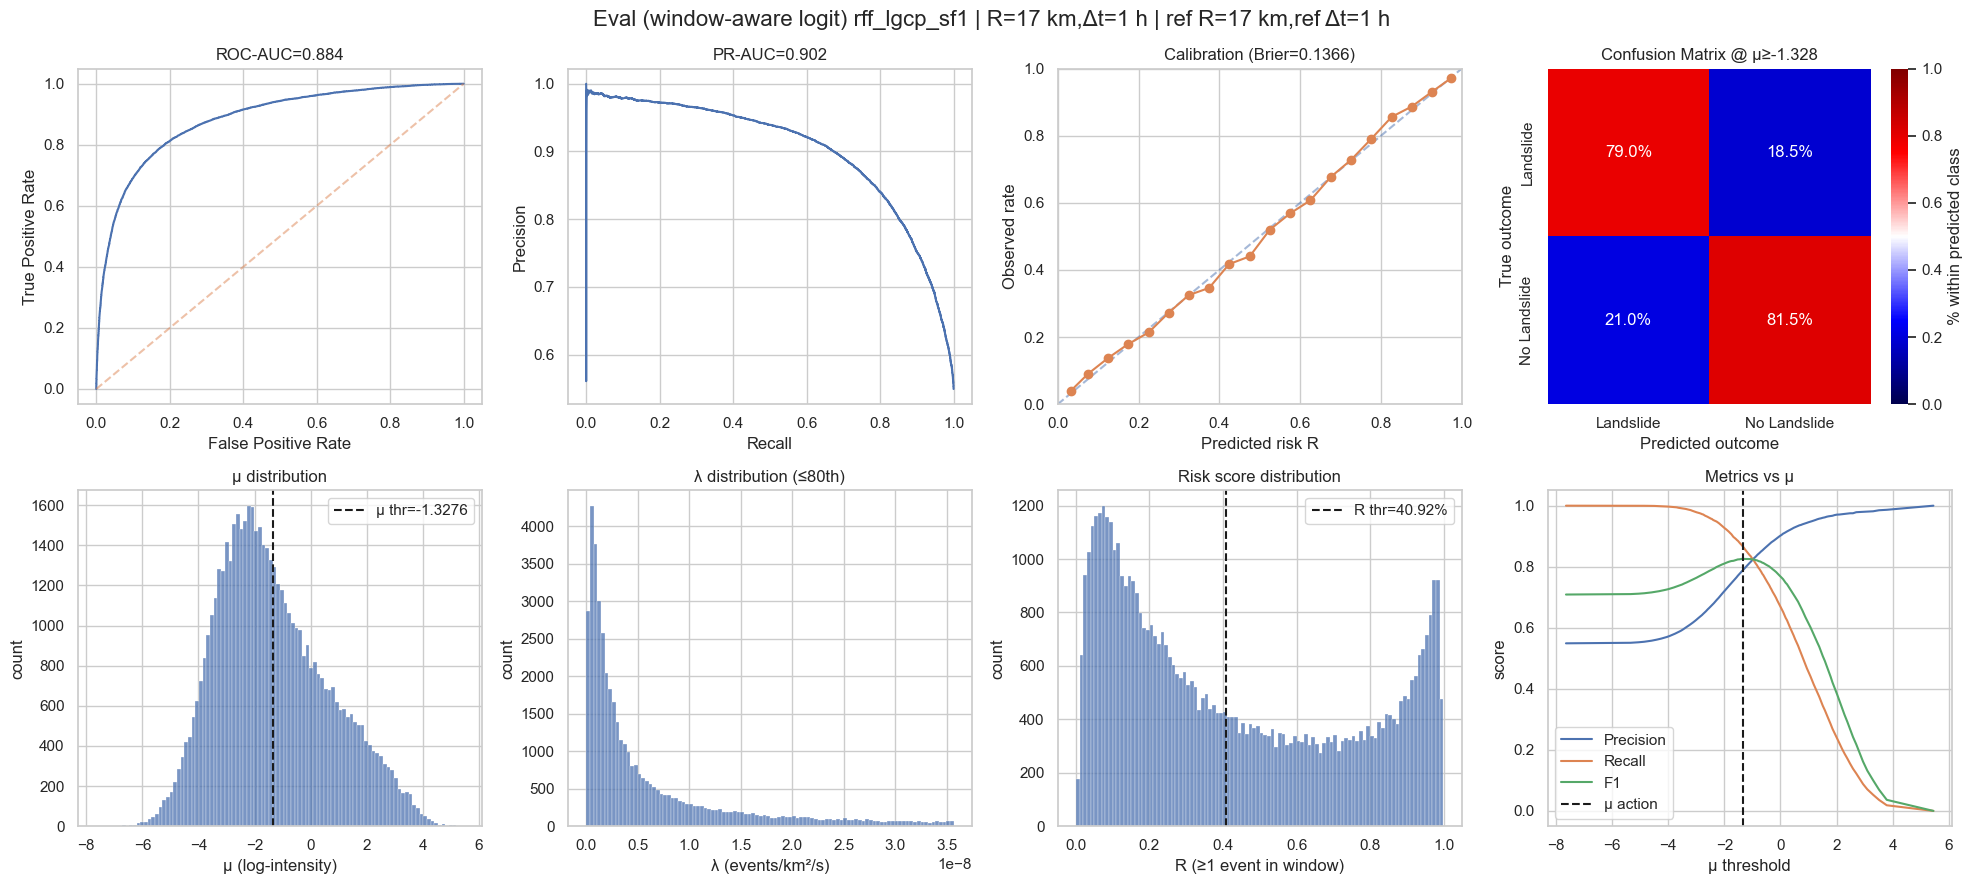

In [15]:
# initialize ATLAS
atlasv2=ATLAS(dF_pca,merged_splits,H)

# fit once and save calibrator then plot evaluation chart:
atlasv2.fit_logit_calibrator(save_path=os.path.join(config_path.get('models'), f'logit_sf{atlasv2.sf_id}.joblib'))
atlasv2.plot_eval(R_km=17.0,dt_hours=1.0,log_s=log_s,lam_clip_pct=80,R_ref_km=17)